### Utils

In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca(model):
  pca = PCA(n_components=2)
  pca_data = pca.fit_transform(model.WE.weight.data.cpu().numpy())

  plt.figure(figsize=(7, 7))
  for i, d in enumerate(pca_data):
    plt.scatter(d[0], d[1], alpha=0.5)
    plt.text(d[0], d[1], i)

  plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
  plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
  plt.show()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
def hm(data, title=None, xaxis_name=None, yaxis_name=None):
  sns.heatmap(data.cpu(), annot=True, cmap='viridis', square=True, center=0, fmt='.1f')

  plt.title(title)
  plt.xlabel(xaxis_name)
  plt.ylabel(yaxis_name)
  plt.show()

### Global

In [3]:
base = 5
epochs = 10000
learning_rate = 0.00005

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Transformer

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import math

class TF(nn.Module):
    def __init__(self, n_vocab=base, d_model=5, emb_dim=5):
        super(TF, self).__init__()
        torch.manual_seed(42)

        # ff_dim = d_model * 4
        ff_dim = d_model

        self.WE = nn.Embedding(n_vocab, emb_dim)
        # self.WQ = nn.Linear(d_model, d_model, bias=False)
        # self.WK = nn.Linear(d_model, d_model, bias=False)
        self.WV = nn.Linear(emb_dim, d_model, bias=False)
        self.W1 = nn.Linear(d_model, ff_dim, bias=False)
        self.W2 = nn.Linear(ff_dim, emb_dim, bias=False)
        # self.WL = nn.Linear(d_model, n_vocab, bias=False)

    def forward(self, x, log=False):
        if log: print(f'x: {x}')
        batch_size, seq_len = x.shape
        E = self.WE(x) # E: (b, t, d_model)
        if log: print(f'E: {E}')

        # Q = self.WQ(E)
        # K = self.WK(E)
        # att_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(E.size(-1))
        att_scores = torch.ones((seq_len, seq_len)) # Ablate Q, K

        att_weight = F.softmax(att_scores, dim=-1).to(device)

        V = self.WV(E)
        # V = E # Ablate WV
        if log: print(f'V: {V}')

        att = att_weight @ V
        if log: print(f'att: {att}')

        FNN = self.W2(F.relu(self.W1(att)))
        # FNN = F.relu(self.W1(att)) # Ablate W2
        # FNN = self.W1(att) # Ablate W2+ReLU (X)
        # FNN = att # Ablate FFN (X)
        if log: print(f'FNN: {FNN}')

        # L = self.WL(FNN)
        L = FNN @ self.WE.weight.t()  # Use shared weight
        # L = FNN # Ablate WL
        if log: print(f'L: {L}')

        return L[:,-1,:] # only next token

In [6]:
inputs = []
labels = []

for i in range(base):
    for j in range(base):
        inputs.append([i, j])
        labels.append((i + j) % base)

inputs = torch.LongTensor(inputs).to(device)
labels = torch.LongTensor(labels).to(device)

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
model = TF().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

print(sum(p.numel() for p in model.parameters()), 'parameters')

100 parameters


In [8]:
# import math

# WE = torch.ones_like(model.WE.weight.data)

# thetas = torch.linspace(0, 2 * math.pi, steps=base+1)
# for i in range(base):
#   WE[i] = torch.tensor([math.cos(thetas[i]), math.sin(thetas[i])])

# model.WE.weight.data = WE.to(device)
# model.WE.weight.requires_grad = False
# hm(model.WE.weight.data, title='WE', xaxis_name='emb_dim', yaxis_name='token')

# model.WL.weight.data = WE.to(device) # tie weights
# model.WL.weight.requires_grad = False
# hm(model.WL.weight.data.T, title='WL', xaxis_name='emb_dim', yaxis_name='token')

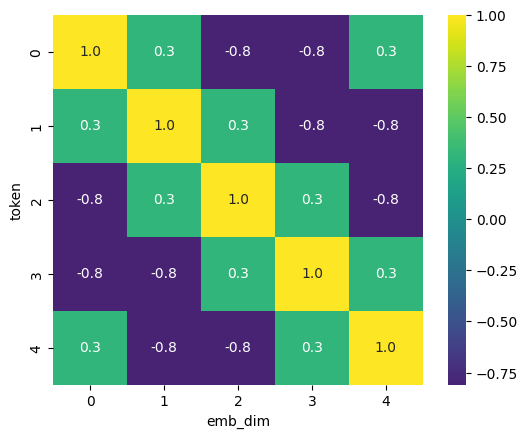

In [9]:
WE = model.WE.weight.data.cpu().detach()

import numpy as np
y = np.cos(2 * np.pi * np.arange(base*2) / base)

rad = 1
for row in range(base):
    for col in range(base):
        WE[row, col] = rad * y[base+row-col]

model.WE.weight.data = WE.to(device)
model.WE.weight.requires_grad = False
hm(model.WE.weight.data, xaxis_name='emb_dim', yaxis_name='token')

In [10]:
# WL = model.WL.weight.data.cpu().detach()
# WL = torch.ones_like(WL)
# model.WL.weight.data = WL.to(device)
# model.WL.weight.requires_grad = False
# hm(model.WL.weight.data)

Epoch 1	 Loss: 1.612449	 Acc: 0.240000


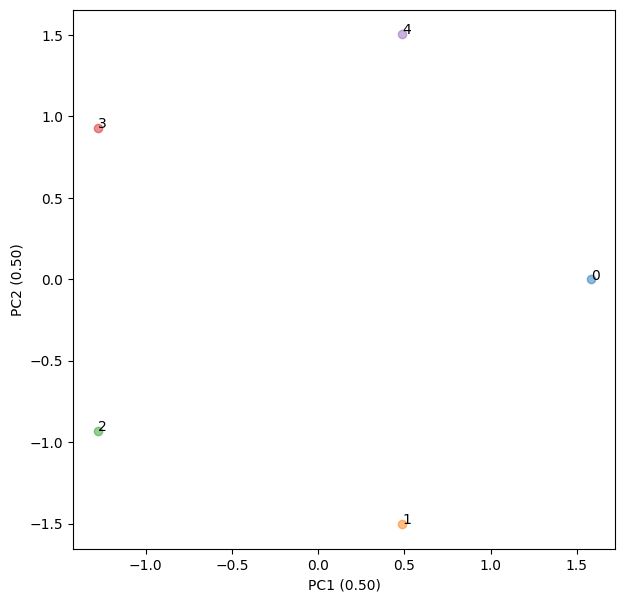

Epoch 100	 Loss: 1.552506	 Acc: 0.320000
Epoch 200	 Loss: 1.508526	 Acc: 0.320000
Epoch 300	 Loss: 1.462167	 Acc: 0.520000
Epoch 400	 Loss: 1.414536	 Acc: 0.520000
Epoch 500	 Loss: 1.364497	 Acc: 0.640000
Epoch 600	 Loss: 1.312881	 Acc: 0.640000
Epoch 700	 Loss: 1.260422	 Acc: 0.720000
Epoch 800	 Loss: 1.207811	 Acc: 0.720000
Epoch 900	 Loss: 1.155400	 Acc: 0.720000
Epoch 1000	 Loss: 1.104462	 Acc: 0.720000


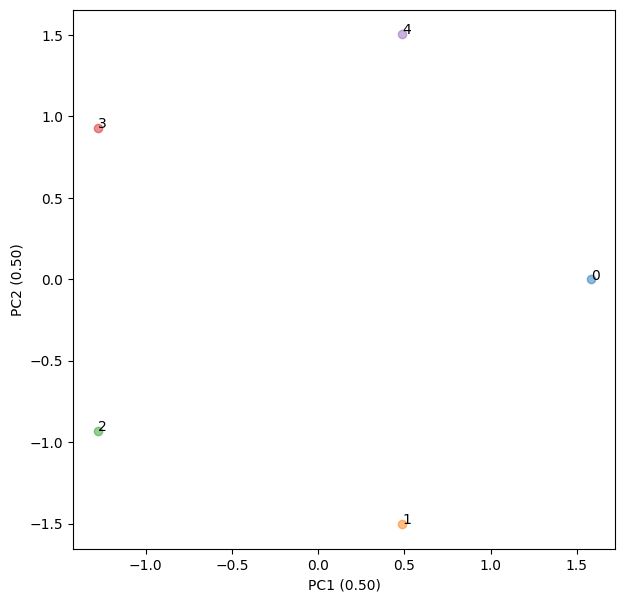

Epoch 1100	 Loss: 1.054121	 Acc: 0.720000
Epoch 1200	 Loss: 1.004571	 Acc: 0.720000
Epoch 1300	 Loss: 0.956568	 Acc: 0.720000
Epoch 1400	 Loss: 0.910860	 Acc: 0.800000
Epoch 1500	 Loss: 0.868005	 Acc: 0.800000
Epoch 1600	 Loss: 0.828835	 Acc: 0.800000
Epoch 1700	 Loss: 0.792920	 Acc: 0.800000
Epoch 1800	 Loss: 0.760151	 Acc: 0.800000
Epoch 1900	 Loss: 0.729846	 Acc: 0.800000
Epoch 2000	 Loss: 0.701559	 Acc: 0.800000


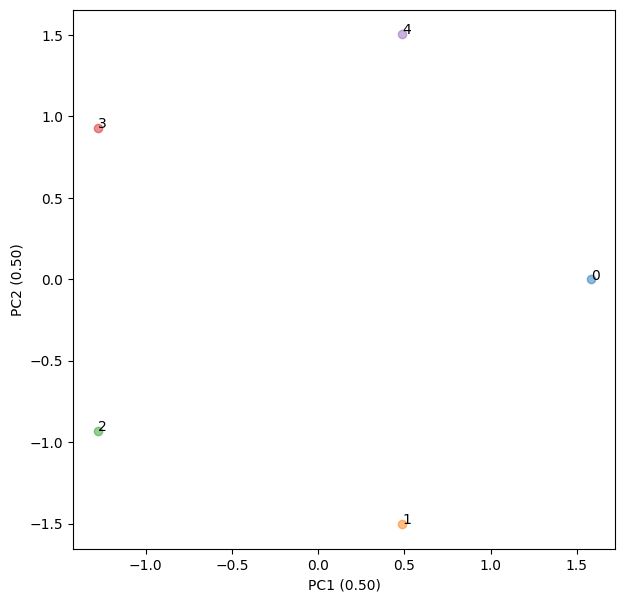

Epoch 2100	 Loss: 0.674414	 Acc: 0.800000
Epoch 2200	 Loss: 0.648122	 Acc: 0.800000
Epoch 2300	 Loss: 0.622527	 Acc: 0.800000
Epoch 2400	 Loss: 0.597233	 Acc: 0.800000
Epoch 2500	 Loss: 0.572401	 Acc: 0.800000
Epoch 2600	 Loss: 0.548066	 Acc: 0.800000
Epoch 2700	 Loss: 0.524250	 Acc: 0.800000
Epoch 2800	 Loss: 0.500881	 Acc: 0.800000
Epoch 2900	 Loss: 0.478132	 Acc: 0.800000
Epoch 3000	 Loss: 0.455983	 Acc: 0.800000


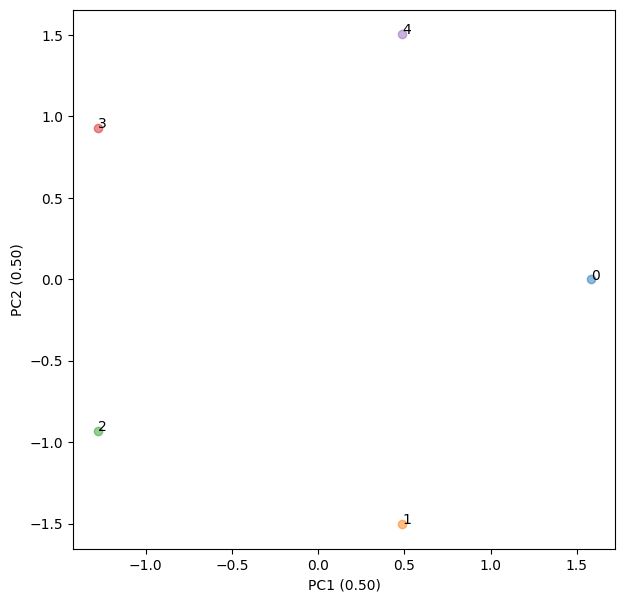

Epoch 3100	 Loss: 0.434295	 Acc: 0.800000
Epoch 3200	 Loss: 0.413254	 Acc: 0.800000
Epoch 3300	 Loss: 0.392961	 Acc: 0.800000
Epoch 3400	 Loss: 0.373398	 Acc: 0.920000
Epoch 3500	 Loss: 0.354744	 Acc: 0.920000
Epoch 3600	 Loss: 0.337141	 Acc: 0.920000
Epoch 3700	 Loss: 0.320506	 Acc: 0.920000
Epoch 3800	 Loss: 0.305042	 Acc: 0.920000
Epoch 3900	 Loss: 0.290655	 Acc: 0.920000
Epoch 4000	 Loss: 0.277178	 Acc: 0.920000


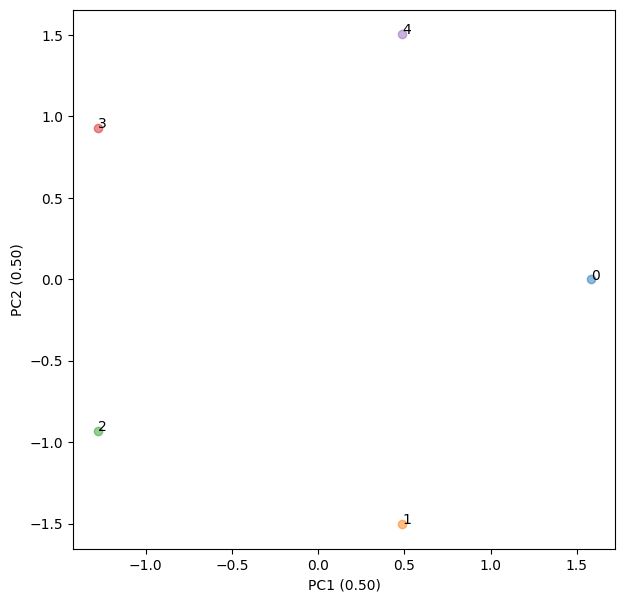

Epoch 4100	 Loss: 0.264683	 Acc: 0.920000
Epoch 4200	 Loss: 0.253258	 Acc: 0.920000
Epoch 4300	 Loss: 0.242760	 Acc: 0.920000
Epoch 4400	 Loss: 0.233094	 Acc: 0.920000
Epoch 4500	 Loss: 0.224248	 Acc: 0.920000
Epoch 4600	 Loss: 0.216045	 Acc: 0.920000
Epoch 4700	 Loss: 0.208517	 Acc: 0.920000
Epoch 4800	 Loss: 0.201567	 Acc: 0.920000
Epoch 4900	 Loss: 0.195113	 Acc: 0.920000
Epoch 5000	 Loss: 0.189192	 Acc: 0.920000


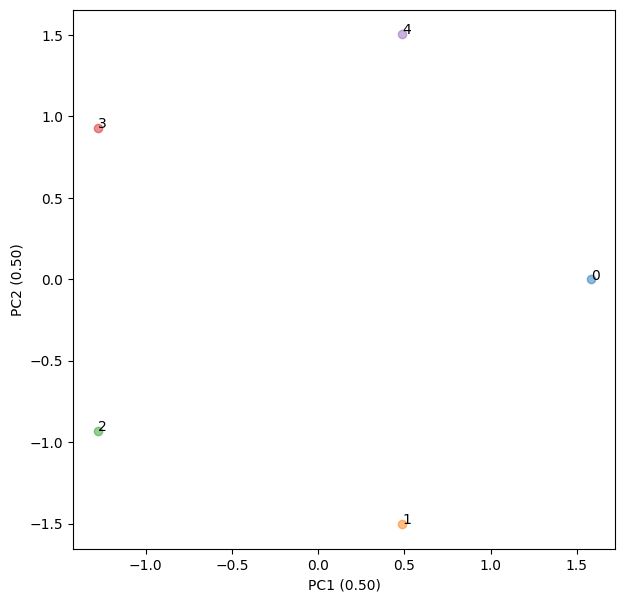

Epoch 5100	 Loss: 0.183697	 Acc: 0.920000
Epoch 5200	 Loss: 0.178714	 Acc: 0.920000
Epoch 5300	 Loss: 0.173986	 Acc: 0.920000
Epoch 5400	 Loss: 0.169690	 Acc: 0.920000
Epoch 5500	 Loss: 0.165786	 Acc: 0.920000
Epoch 5600	 Loss: 0.162123	 Acc: 0.920000
Epoch 5700	 Loss: 0.158795	 Acc: 0.920000
Epoch 5800	 Loss: 0.155746	 Acc: 0.920000
Epoch 5900	 Loss: 0.152984	 Acc: 0.920000
Epoch 6000	 Loss: 0.150420	 Acc: 0.920000


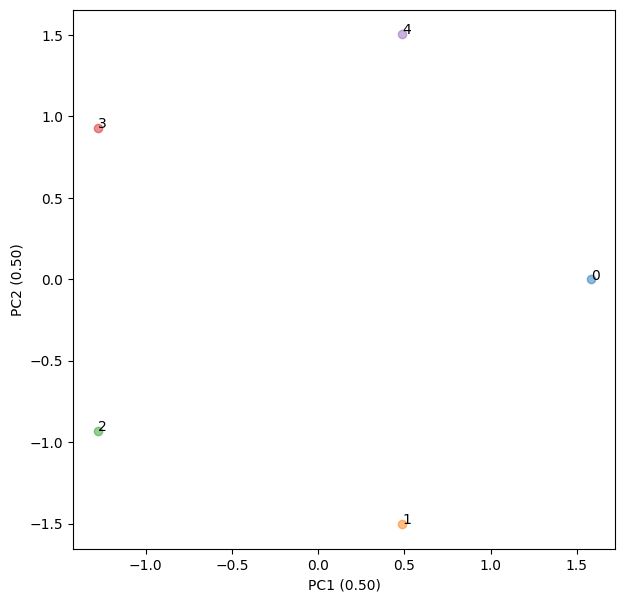

Epoch 6100	 Loss: 0.148123	 Acc: 0.920000
Epoch 6200	 Loss: 0.146023	 Acc: 0.920000
Epoch 6300	 Loss: 0.144137	 Acc: 0.920000
Epoch 6400	 Loss: 0.142424	 Acc: 0.920000
Epoch 6500	 Loss: 0.140860	 Acc: 0.920000
Epoch 6600	 Loss: 0.139451	 Acc: 0.920000
Epoch 6700	 Loss: 0.138158	 Acc: 0.920000
Epoch 6800	 Loss: 0.136988	 Acc: 0.920000
Epoch 6900	 Loss: 0.132257	 Acc: 0.920000
Epoch 7000	 Loss: 0.105015	 Acc: 1.000000


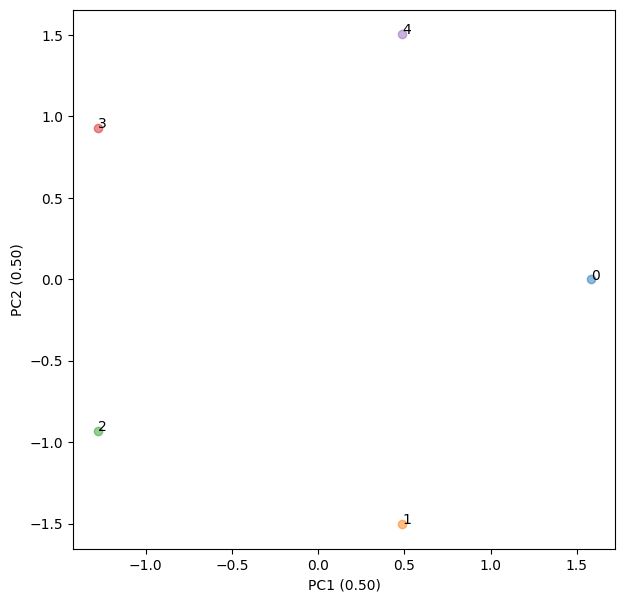

Epoch 7100	 Loss: 0.074558	 Acc: 1.000000
Epoch 7200	 Loss: 0.049642	 Acc: 1.000000
Epoch 7300	 Loss: 0.031558	 Acc: 1.000000
Epoch 7400	 Loss: 0.019567	 Acc: 1.000000
Epoch 7500	 Loss: 0.012047	 Acc: 1.000000
Epoch 7600	 Loss: 0.007481	 Acc: 1.000000
Epoch 7700	 Loss: 0.004771	 Acc: 1.000000
Epoch 7800	 Loss: 0.003127	 Acc: 1.000000
Epoch 7900	 Loss: 0.002106	 Acc: 1.000000
Epoch 8000	 Loss: 0.001444	 Acc: 1.000000


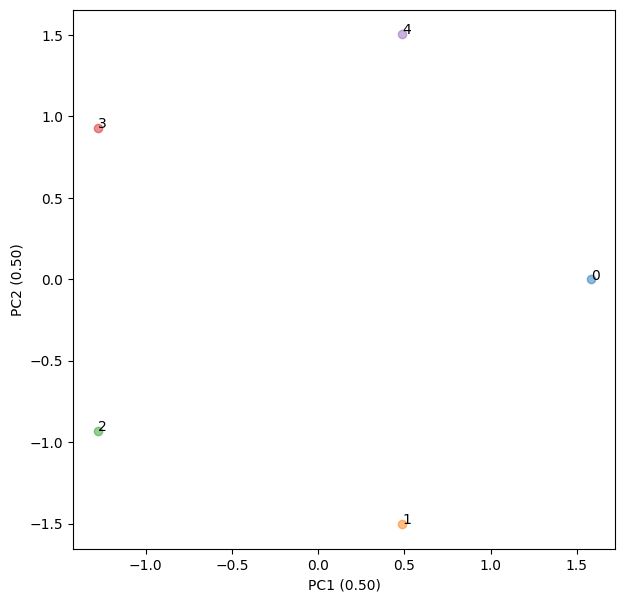

Epoch 8100	 Loss: 0.001004	 Acc: 1.000000
Epoch 8200	 Loss: 0.000704	 Acc: 1.000000
Epoch 8300	 Loss: 0.000497	 Acc: 1.000000
Epoch 8400	 Loss: 0.000354	 Acc: 1.000000
Epoch 8500	 Loss: 0.000252	 Acc: 1.000000
Epoch 8600	 Loss: 0.000180	 Acc: 1.000000
Epoch 8700	 Loss: 0.000129	 Acc: 1.000000
Epoch 8800	 Loss: 0.000091	 Acc: 1.000000
Epoch 8900	 Loss: 0.000065	 Acc: 1.000000
Epoch 9000	 Loss: 0.000046	 Acc: 1.000000


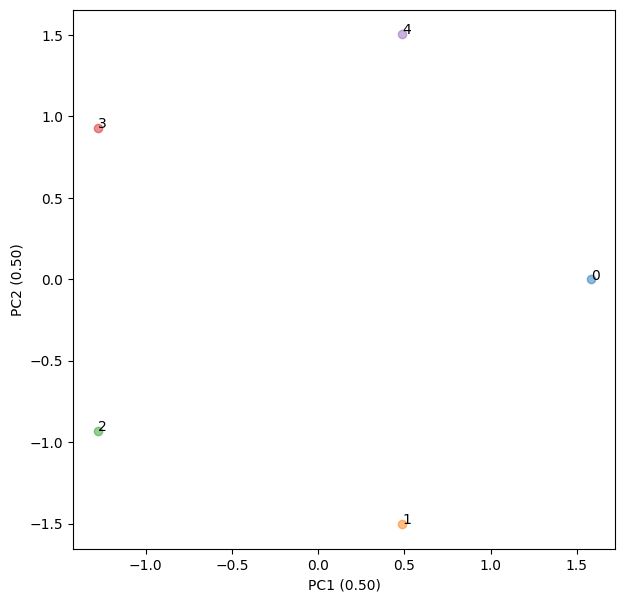

Epoch 9100	 Loss: 0.000032	 Acc: 1.000000
Epoch 9200	 Loss: 0.000022	 Acc: 1.000000
Epoch 9300	 Loss: 0.000016	 Acc: 1.000000
Epoch 9400	 Loss: 0.000011	 Acc: 1.000000
Epoch 9500	 Loss: 0.000007	 Acc: 1.000000
Epoch 9600	 Loss: 0.000005	 Acc: 1.000000
Epoch 9700	 Loss: 0.000003	 Acc: 1.000000
Epoch 9800	 Loss: 0.000002	 Acc: 1.000000
Epoch 9900	 Loss: 0.000002	 Acc: 1.000000
Epoch 10000	 Loss: 0.000001	 Acc: 1.000000


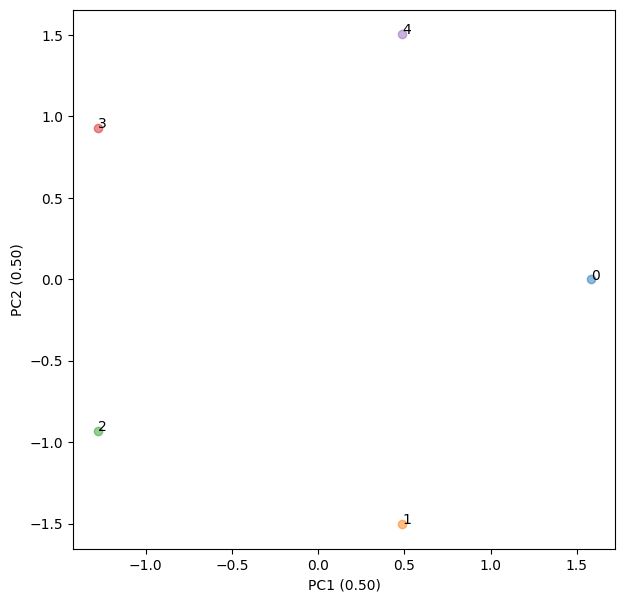

In [11]:
losses = []
for epoch in range(epochs):
    model.train()
    total = correct = loss_sum = 0
    for batch, (x, y) in enumerate(dataloader):

        optimizer.zero_grad()

        pred = model(x)
        total += len(y)
        correct += (torch.argmax(pred, dim=1) == y).count_nonzero()
        loss = loss_fn(pred, y)
        loss_sum += loss.item()

        loss.backward()

        optimizer.step()

        # # Weight clamp
        # with torch.no_grad():
        #   for param in model.parameters():
        #     param.clamp_(min=-2, max=2)

    losses.append(loss_sum/total)
    if epoch == 0 or (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}\t Loss: {losses[-1]:6f}\t Acc: {correct/total:4f}")
    if epoch == 0 or (epoch+1) % 1000 == 0:
        plot_pca(model)
        pass

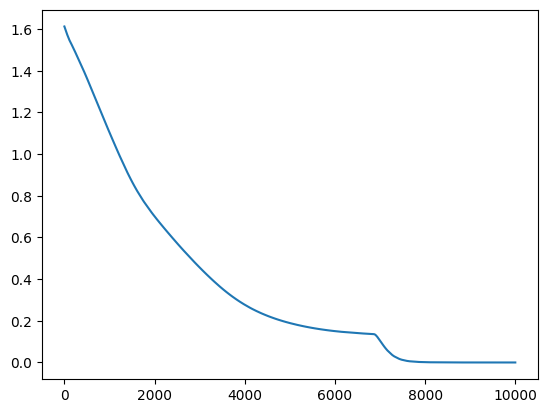

In [12]:
plt.plot(losses)

In [13]:
model.eval()
with torch.no_grad():
    pred = model(inputs)
    labels = torch.argmax(pred, dim=1)

err = 0
for i in range(base**2):
  if inputs[i].data.sum().item() % base != labels[i].item():
    err += 1
    print(inputs[i], labels[i])
print('Error: ', err)

Error:  0


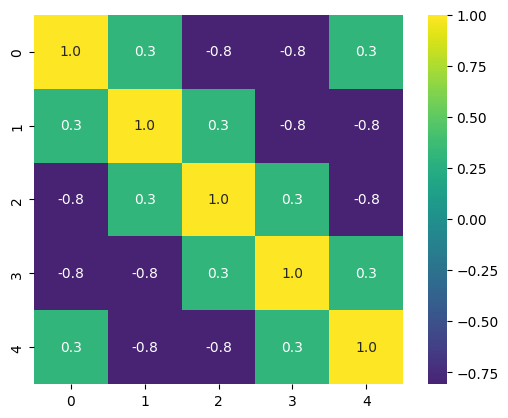

In [14]:
hm(model.WE.weight.data)

In [15]:
try:
    hm(model.WQ.weight.data)
    hm(model.WK.weight.data)

    att_scores = torch.matmul(model.WQ.weight.data, model.WK.weight.data.transpose(-2, -1)) / math.sqrt(model.WE.weight.data.size(-1))
    att_weight = F.softmax(att_scores, dim=-1)
    hm(att_weight)
except Exception as e:
    print(e)

'TF' object has no attribute 'WQ'


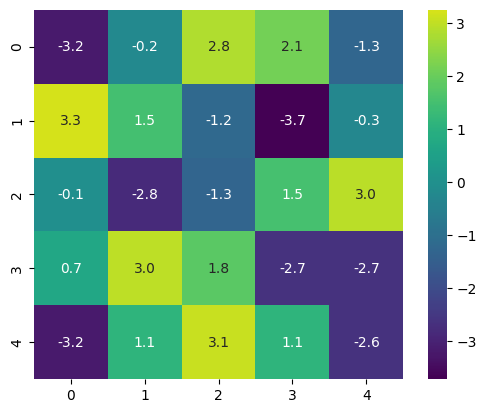

tensor([[-3.2021, -0.2326,  2.8309,  2.1360, -1.2955],
        [ 3.2581,  1.4925, -1.2066, -3.7250, -0.2787],
        [-0.0522, -2.8364, -1.3058,  1.5192,  2.9546],
        [ 0.7191,  2.9639,  1.7879, -2.6599, -2.6595],
        [-3.1858,  1.1225,  3.0914,  1.1233, -2.6416]], device='cuda:0')

In [16]:
hm(model.WV.weight.data)
model.WV.weight.data

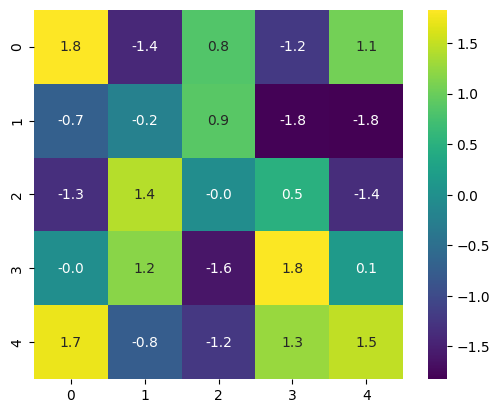

tensor([[ 1.8305, -1.4206,  0.8389, -1.2164,  1.0526],
        [-0.7171, -0.2259,  0.8739, -1.7993, -1.8252],
        [-1.3302,  1.4185, -0.0461,  0.4895, -1.3567],
        [-0.0274,  1.1750, -1.6125,  1.8073,  0.1500],
        [ 1.7236, -0.7677, -1.2270,  1.2695,  1.4843]], device='cuda:0')

In [17]:
hm(model.W1.weight.data)
model.W1.weight.data

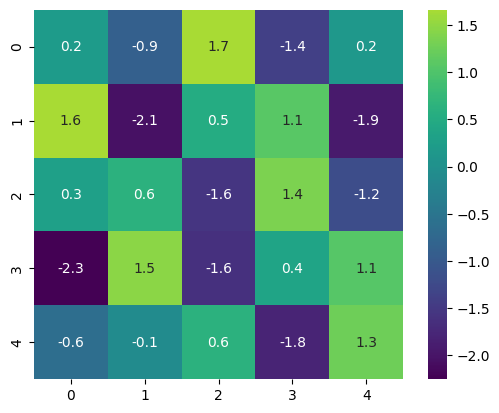

tensor([[ 0.1974, -0.8905,  1.6609, -1.3888,  0.1512],
        [ 1.6468, -2.0534,  0.5210,  1.0784, -1.9426],
        [ 0.2980,  0.6291, -1.5538,  1.3649, -1.2030],
        [-2.2521,  1.4725, -1.6111,  0.3627,  1.0607],
        [-0.6408, -0.0834,  0.6112, -1.7972,  1.2625]], device='cuda:0')

In [18]:
hm(model.W2.weight.data)
model.W2.weight.data

In [19]:
try:
    hm(model.WL.weight.data)
except Exception as e:
    print(e)

'TF' object has no attribute 'WL'


In [20]:
model(torch.tensor([[1, 2]]).to(device), log=True)

x: tensor([[1, 2]], device='cuda:0')
E: tensor([[[ 0.3090,  1.0000,  0.3090, -0.8090, -0.8090],
         [-0.8090,  0.3090,  1.0000,  0.3090, -0.8090]]], device='cuda:0')
V: tensor([[[-1.0273,  5.3656, -6.8755,  8.0421,  2.3216],
         [ 7.0577, -4.3069, -4.0609,  3.4517,  8.4998]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)
att: tensor([[[ 3.0152,  0.5293, -5.4682,  5.7469,  5.4107],
         [ 3.0152,  0.5293, -5.4682,  5.7469,  5.4107]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)
FNN: tensor([[[-24.4898, -29.9500,  -4.2171,  35.9116,  -3.0719],
         [-24.4898, -29.9500,  -4.2171,  35.9116,  -3.0719]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)
L: tensor([[[-60.3355, -65.3887,  19.9230,  77.7018,  28.0993],
         [-60.3355, -65.3887,  19.9230,  77.7018,  28.0993]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)


tensor([[-60.3355, -65.3887,  19.9230,  77.7018,  28.0993]], device='cuda:0',
       grad_fn=<SliceBackward0>)